In [95]:
%load_ext autoreload
%autoreload 2

import os
from src.video_preprocessing.download_videos.youtube_download import preprocess_video
from src.video_preprocessing.scene_detection.scene_detect import detect_scenes
from src.video_preprocessing.download_videos.download_utils import (
    transcribe_audio_files,
    extract_and_store_audio,
)
from src.ocr.pytesseract_image_to_text import extract_text_from_image
from sentence_transformers import SentenceTransformer
from src.text_embedder.embedder import text_to_embedding_transformer

from PIL import Image

import torch
from loguru import logger
import pickle

from src.clip.clip_model import CLIPEmbeddingsModel

import tqdm
from pathlib import Path
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Pipeline
Download a video from a specific URL on YouTube, then run:
- Scene detection
- Keyframe detection

The resulting data will be stored under `/data/raw/<NAME>`

In [2]:
# Define options and input for downloading a video from youtube

# INSERT video name here
name = "biology_chapter_3_3"
# INSERT video URL here
url = "https://youtu.be/DZSEErNZ1d4?si=f6YxKQ9rP6iqgTfk"
# INSERT chunk length in seconds 30s --> 30, no splitting: None
chunks = None

opts_aud = {"format": "mp3/bestaudio/best", "keep-video": True}
opts_vid = {"format": "mp4/bestvideo/best"}

In [3]:
# Downloads the video creates the relevant datafolders and transcribes the video
data_path = preprocess_video(
    download=True,
    uploaded_vid="ignore",  # path to local file
    url=url,
    name=name,
    aud_opts=opts_aud,
    vid_opts=opts_vid,  # Video download settings
    audio_file=name + ".mp3",
    input_file=name + ".mp4",
    output="output.mp4",
    split_length=chunks,
)

2024-06-26 11:12:32.228 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:49 - Starting AutoCaptioning...
2024-06-26 11:12:32.243 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:50 - Results will be stored in data/raw/biology_chapter_3_3
2024-06-26 11:12:32.243 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:58 - Created chunks folders


[youtube] Extracting URL: https://youtu.be/DZSEErNZ1d4?si=f6YxKQ9rP6iqgTfk
[youtube] DZSEErNZ1d4: Downloading webpage
[youtube] DZSEErNZ1d4: Downloading ios player API JSON
[youtube] DZSEErNZ1d4: Downloading m3u8 information
[info] DZSEErNZ1d4: Downloading 1 format(s): 18
[download] C:\Users\baatout\PycharmProjects\afm-vlm\data\raw\biology_chapter_3_3\biology_chapter_3_3.mp4 has already been downloaded
[download] 100% of   85.73MiB


2024-06-26 11:12:35.519 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:91 - Video is not splitted:
2024-06-26 11:12:35.519 | INFO     | src.video_preprocessing.download_videos.youtube_download:preprocess_video:95 - Video downloaded successfully!


In [ ]:
#  Now that we have downloaded the video we want to perform scene_Detection:
detect_scenes(data_path)

2024-06-25 20:21:09.819 | INFO     | src.video_preprocessing.scene_detection.scene_detect:detect_scenes:29 - Found file
2024-06-25 20:21:09.835 | INFO     | src.video_preprocessing.scene_detection.scene_detect:detect_scenes:33 - Name:biology_chapter_3_3.mp4,dirname:C:\Users\baatout\PycharmProjects\afm-vlm\data/raw\biology_chapter_3_3\biology_chapter_3_3.mp4
2024-06-25 20:21:09.837 | INFO     | src.video_preprocessing.scene_detection.scene_detect:detect_scenes:35 - Running scene_detection:


In [ ]:
# Extract the audio per detected scene
extract_and_store_audio(
    os.path.join(data_path, "scene_snippets"),
    os.path.join(data_path, "audio_chunks"),
)

# Audio Transcription using Whisper

For Faster Inference Please Use Tiny!

In [12]:
# Transcribe the different snippets:
audio_dir = os.path.join(data_path, "audio_chunks")
transcriptions_dir = os.path.join(data_path, "transcriptions")

model_type = "tiny"  # change to 'large' if you want more accurate results,
# change to 'medium.en' or 'large.en' for all english language tasks,
# and change to 'small' or 'base' for faster inference
lang = "en"

# Run whisper on all .wav files in audio_dir
transcribe_audio_files(audio_dir, transcriptions_dir, model_type=model_type, lang=lang)

2024-06-25 23:57:07.443 | INFO     | src.video_preprocessing.download_videos.download_utils:transcribe_audio_files:361 - Starting pooling:
100%|██████████| 141/141 [04:53<00:00,  2.08s/it]


# Load the CLIP Model

In [101]:
# create instance
clip_model = CLIPEmbeddingsModel()

<Figure size 800x2000 with 0 Axes>

In [108]:
# get current directory
# Get the path of the current notebook
notebook_path = Path().resolve()
image_path = os.path.join(
    notebook_path, "data", "raw", "biology_chapter_3_3", "extracted_keyframes"
)

images = []
# make a list out of the images
for image in os.listdir(image_path):
    if image.endswith(".jpg"):
        images.append(os.path.join(image_path, image))

# load and process the dataset
image_dataset = clip_model.load_and_process_dataset(images)

logger.info(f"Image_dataset: {image_dataset}")

2024-06-27 19:42:19.324 | INFO     | __main__:<module>:17 - Image_dataset: [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237E456B3E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x237E456BA70>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC4A70>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC7950>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC4080>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC4D40>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC7FE0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC5AC0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC7B30>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC7A40>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=482x360 at 0x23811EC6D20>, <PIL.JpegImagePlugin.J

# Starting the Analysis of the Information Contained in the Video

### Inputs

* **Transcriptions**: [insert description or link to transcription]
* **Extraction from Slides using OCR**: [insert description or link to extracted content]
* **Textual Interpretation of Visual Information using LLAVA**: [insert description or link to 
interpreted information]

In [ ]:
from src.llm.ollama_implementation.ollama_experiment import (
    prompt_llm_summary,
    generate_caption_using_llava,
    prompt_llm_extensive_summary,
)
from src.video_preprocessing.download_videos.download_utils import (
    transcription_to_text,
    create_metadata,
)

# Transform transcription file
keyframes = {}
ocr_extracted_text = []

for filename in tqdm.tqdm(os.listdir(image_path)):
    # Check if the file ends with the specified extension
    if filename.endswith(".jpg"):
        filepath = os.path.join(image_path, filename)
        keyframe_num = int(filename.split("-")[2])

        # Extract text using OCR:
        ocr_text = extract_text_from_image(filepath)

        # logger.info(f"OCR_results: {ocr_text}")

        transcription_file_path = os.path.join(
            os.path.dirname(image_path),
            "transcriptions",
            filename.replace("-01.jpg", ".csv"),
        )

        transcription, timestamps = transcription_to_text(transcription_file_path)
        logger.info(f"Transcription_text: {transcription}")

        # Extract textual understanding of Visual features using LLAVA:

        #llava_results = generate_caption_using_llava(filepath)
        llava_results = "llava_results"
        logger.info(f"LLava_results: {llava_results}")

        clip_llm_summary = prompt_llm_summary(
            slide_content=ocr_text,
            transcription=transcription,
            llava_output=llava_results,
        )

        extensive_summary = prompt_llm_extensive_summary(
            slide_content=ocr_extracted_text,
            transcription=transcription,
            llava_output=llava_results,
        )

        # Alternative that goes faster.
        # ocr_text = "ocr_text"
        # llava_results = "llava_results"
        # clip_llm_summary = "clip_llm_summary"
        # extensive_summary = "extensive_summary"

        # generate embeddings
        opened_image = Image.open(filepath)

        embeddings = clip_model.generate_image_embeddings(
            clip_llm_summary, opened_image
        )
        clip_text_embedding = embeddings["text_embeds"]
        clip_image_embedding = embeddings["image_embeds"]

        keyframe, keyframe_metadata = create_metadata(
            keyframe_num,
            filepath,
            timestamps,
            transcription,
            ocr_extracted_text,
            llava_results,
            clip_llm_summary,
            extensive_summary,
            clip_text_embedding,
            clip_image_embedding,
        )
        keyframes[keyframe] = keyframe_metadata
        # print(keyframes)

    # Save keyframes dictionary as Pickle

# Save with pickle
with open("data.pickle", "wb") as file:
    pickle.dump(keyframes, file)

  0%|          | 0/143 [00:00<?, ?it/s]2024-06-26 11:06:04.504 | INFO     | src.ocr.pytesseract_image_to_text:extract_text_from_image:17 - Extracted text: Chapter 3:

Nutrients & Membrane Transport
**Is It Possible to Supplement Your
Way to Better Performance & Health?

Biology 1020:
CURRENT TOPICS IN
BIOLOGY


2024-06-26 11:06:04.519 | INFO     | __main__:<module>:36 - Transcription_text:  Welcome to Chapter 3, Nutrients, Membranes and Trane.
2024-06-26 11:06:04.527 | INFO     | __main__:<module>:42 - LLava_results: llava_results


In [109]:
# Assuming keyframes is your dictionary
keyframes_count = len(keyframes)
print("Number of keyframes:", keyframes_count)

NameError: name 'keyframes' is not defined

# Test 1: Search for exact similar Text.

In [118]:
import pandas as pd

# Load csv file
filename = "test_frames_gt.csv"
df = pd.read_csv(filename)

In [119]:
df['Prompt']

0                                     learning outcomes
1     retrieve the main learning outcomes from the l...
2                    explain proteins in macronutrients
3     I did not understand the function of proteins ...
4                                     fish oil capsules
5     what is the functioning of fish oil capsules a...
6                              calcium as micronutrient
7             what is calcium commonly supplemented for
8                                 flavanol food sources
9     what are the main food sources of lycopene red...
10                                      plasma membrane
11                                          chloroplast
12    explain subcellular structures such as the str...
13                                           centrioles
14                 role of centrioles for cell division
15                           transport across membranes
16     passive transport methodologies across membranes
17                                          FDA 

2024-06-27 22:13:36.140 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:36.140 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.156 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([-0.0213,  0.1782,  0.0283,  0.0449,  0.1972,  0.0025,  0.1334, -0.0019,
        -0.0392, -0.0825,  0.0013,  0.0369, -0.0427, -0.0296,  0.1074,  0.0051,
        -0.0812, -0.0677, -0.0275, -0.0263, -0.0206, -0.0898, -0.0332, -0.0047,
         0.0408,  0.0711,  0.1982,  0.1972,  0.0427, -0.0117,  0.1255,  0.2718,
         0.0531,  0.0107,  0.1411,  0.0452, -0.0719,  0.1099,  0.0276, -0.0691,
        -0.0567, -0.0293, -0.0558,  0.0345,  0.0070,  0.0986,  0.0575, -0.0195,
        -0.0565,  0.0400, -0.0810,  0.0239,  0.0753,  0.1718, -0.0234, -0.0170,
         0.0278, -0.0050,  0.0301,  0.0142,  0.1177,  0.0396,  0.0330,  0.

learning outcomes


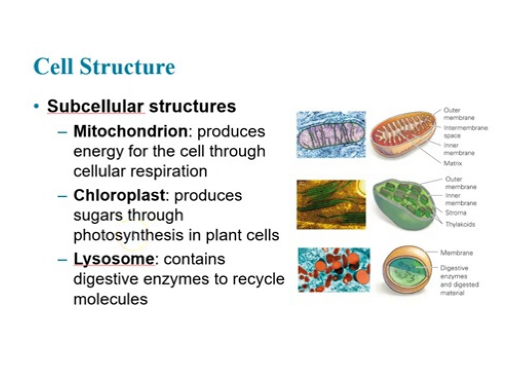

2024-06-27 22:13:36.295 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:36.295 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.295 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 3.7742e-02,  1.3244e-01,  5.4773e-02,  6.7710e-02,  1.4636e-01,
         3.7407e-02,  1.1110e-01, -1.5195e-03, -1.3116e-02, -7.7328e-02,
         2.5751e-02,  1.6371e-02, -2.4989e-02,  8.5245e-02,  6.5022e-02,
         5.9960e-02, -1.1482e-03, -3.7000e-02,  9.4554e-03,  8.3079e-02,
         2.0923e-02, -7.1506e-03, -8.6061e-03, -2.4904e-04,  8.1039e-02,
         1.5254e-01,  1.9310e-01,  1.4636e-01,  1.3590e-01,  1.1716e-02,
         1.9432e-01,  3.0583e-01,  8.2573e-02,  1.9869e-02,  1.1226e-01,
         5.2514e-02, -7.3126e-02,  8.4733e-02,  5.8661e-02,  9.2993e-03,
         2.7223e-02,  1.1177e-01, -2.7264e-02,  1.

retrieve the main learning outcomes from the lecture


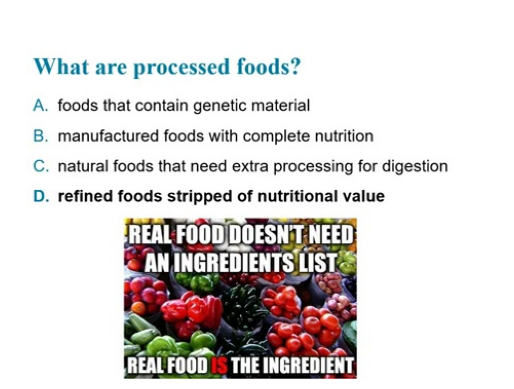

2024-06-27 22:13:36.427 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])


explain proteins in macronutrients


2024-06-27 22:13:36.427 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.443 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.2866, 0.1379, 0.4367, 0.4105, 0.2637, 0.2377, 0.3379, 0.4337, 0.3002,
        0.2332, 0.4078, 0.3769, 0.2595, 0.4602, 0.1721, 0.3348, 0.2463, 0.2488,
        0.3740, 0.4144, 0.3960, 0.2485, 0.2992, 0.2005, 0.4107, 0.5438, 0.2377,
        0.2637, 0.4918, 0.3007, 0.4580, 0.4166, 0.7067, 0.2696, 0.4762, 0.5117,
        0.2226, 0.2063, 0.2840, 0.3080, 0.3946, 0.4923, 0.1758, 0.5325, 0.2491,
        0.4835, 0.5583, 0.4498, 0.4478, 0.5902, 0.3619, 0.4152, 0.5056, 0.4848,
        0.4069, 0.4294, 0.5208, 0.6167, 0.1841, 0.5391, 0.6217, 0.4355, 0.3432,
        0.7343, 0.4647, 0.3800, 0.5056, 0.3719, 0.6053, 0.4446, 0.2862, 0.2568,
        0.2578, 0.2510, 0.2488, 0.3983, 0.2059, 0.5653, 0.6337, 0.1636, 0.4762,
        0.2789, 0.5206, 0.3954, 0.1271, 0.301

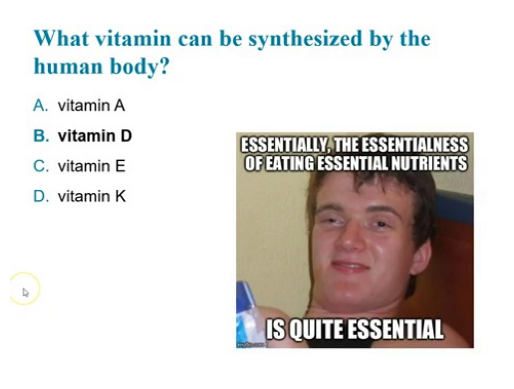

I did not understand the function of proteins in macronutrients


2024-06-27 22:13:36.607 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:36.611 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.611 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.3285, 0.1201, 0.4010, 0.3596, 0.2177, 0.2648, 0.3170, 0.4348, 0.2965,
        0.1768, 0.4134, 0.3703, 0.2902, 0.4259, 0.1948, 0.2938, 0.2493, 0.2732,
        0.3924, 0.4111, 0.4121, 0.2527, 0.3002, 0.1663, 0.4053, 0.5056, 0.2465,
        0.2177, 0.4469, 0.3269, 0.4180, 0.4451, 0.6529, 0.2854, 0.4020, 0.4363,
        0.1628, 0.2148, 0.3104, 0.3416, 0.3472, 0.4439, 0.2372, 0.4689, 0.2228,
        0.4245, 0.5267, 0.5017, 0.4124, 0.5278, 0.3776, 0.3806, 0.4447, 0.4642,
        0.4041, 0.4793, 0.4510, 0.6147, 0.1542, 0.4724, 0.5925, 0.4237, 0.3582,
        0.6831, 0.4472, 0.3847, 0.4447, 0.3790, 0.5409, 0.3849, 0.2956, 0.

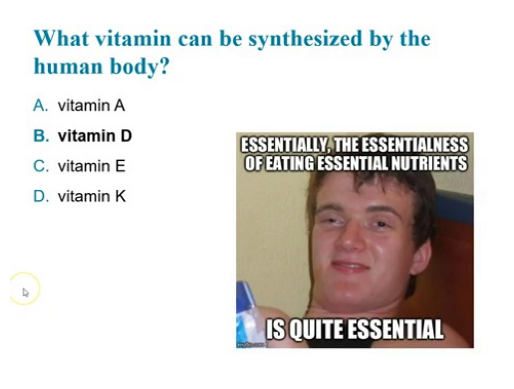

2024-06-27 22:13:36.752 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])


fish oil capsules


2024-06-27 22:13:36.752 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.752 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 2.1376e-01,  1.5088e-01,  5.6009e-02, -2.6860e-02,  9.7211e-02,
         1.7444e-01, -4.5293e-03,  1.1993e-01,  5.4543e-02,  1.3745e-01,
         5.0577e-02,  6.9285e-01,  3.0292e-01, -2.0524e-03,  1.8458e-01,
         2.0183e-01, -3.5533e-02,  6.1874e-02,  2.2720e-01, -9.4810e-02,
         2.2939e-01, -3.4500e-02,  8.1469e-02,  2.9875e-01,  6.0259e-02,
         1.9807e-01,  8.2044e-02,  9.7211e-02,  1.5778e-01,  1.2334e-01,
         1.6625e-01,  8.7682e-02,  1.9167e-01,  1.8535e-01,  2.8355e-01,
         1.4245e-01,  1.3597e-01,  3.5289e-04, -2.8157e-02,  1.8721e-02,
         1.8655e-01,  8.6737e-02,  6.8995e-02,  1.2689e-01,  1.9331e-01,
         1.9426e-01,  3.3727e-01,  1.6849e-01,  1.4826e-04,  1.5366e-01,
         2.2799e-01,  2.1414e-01,  

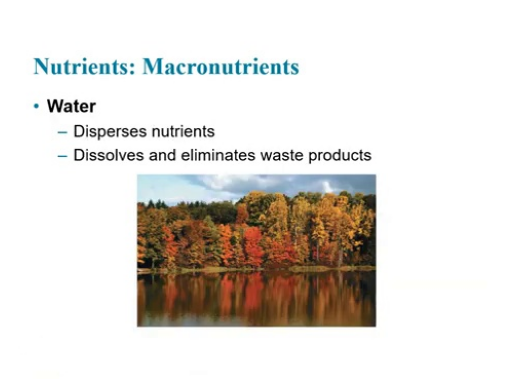

2024-06-27 22:13:36.869 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:36.869 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.869 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 0.2208,  0.1647,  0.3224,  0.2232,  0.3097,  0.3027,  0.2261,  0.2062,
         0.3544,  0.1660,  0.1454,  0.8429,  0.3186,  0.2115,  0.3361,  0.2792,
         0.0467,  0.0900,  0.3037,  0.1026,  0.3094,  0.0404,  0.3735,  0.4253,
         0.0974,  0.3728,  0.2272,  0.3097,  0.3506,  0.1945,  0.3102,  0.2684,
         0.3929,  0.2399,  0.4639,  0.3924,  0.1514,  0.0659,  0.0547,  0.0991,
         0.2742,  0.1974,  0.1455,  0.2778,  0.1652,  0.4136,  0.4699,  0.2420,
         0.2162,  0.4708,  0.2570,  0.2902,  0.3809,  0.3628,  0.0924,  0.2446,
         0.3121,  0.3439,  0.0880,  0.2397,  0.3201,  0.4130,  0.2012,  0.

what is the functioning of fish oil capsules and its relation to vitamins


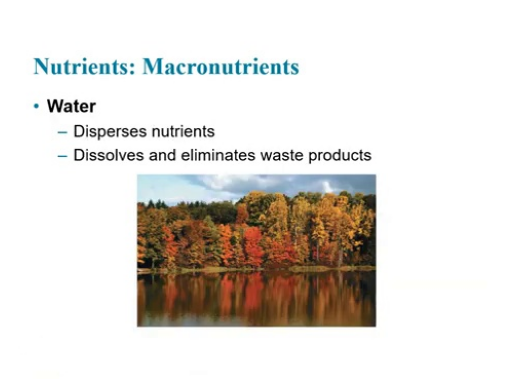

2024-06-27 22:13:36.979 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:36.994 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:36.994 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.2071, 0.2520, 0.6388, 0.4056, 0.3590, 0.2286, 0.4147, 0.1735, 0.4123,
        0.2713, 0.2143, 0.3804, 0.1893, 0.3528, 0.2658, 0.4615, 0.0404, 0.1136,
        0.1099, 0.2436, 0.1319, 0.0388, 0.4162, 0.3405, 0.1078, 0.6850, 0.2314,
        0.3590, 0.6199, 0.2007, 0.5349, 0.3981, 0.4502, 0.2070, 0.4947, 0.4361,
        0.2462, 0.1667, 0.0847, 0.1038, 0.1984, 0.3159, 0.1873, 0.5433, 0.1587,
        0.3946, 0.3647, 0.1660, 0.3880, 0.6802, 0.1777, 0.4590, 0.3610, 0.4206,
        0.2271, 0.1713, 0.5351, 0.4417, 0.1155, 0.5413, 0.3929, 0.5085, 0.1149,
        0.7171, 0.4191, 0.0781, 0.3610, 0.2515, 0.5134, 0.5113, 0.2187, 0.

calcium as micronutrient


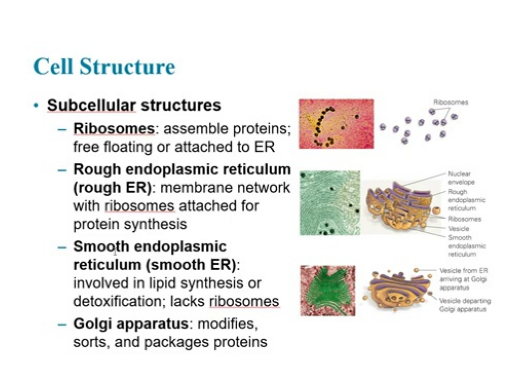

2024-06-27 22:13:37.120 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.120 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.120 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.2099, 0.1982, 0.4949, 0.3183, 0.4189, 0.2955, 0.3591, 0.1892, 0.4397,
        0.2487, 0.2088, 0.4032, 0.1664, 0.3343, 0.3486, 0.5009, 0.0309, 0.1523,
        0.0499, 0.1402, 0.0718, 0.0274, 0.4495, 0.4367, 0.1027, 0.5345, 0.2561,
        0.4189, 0.4741, 0.1648, 0.4403, 0.2802, 0.4037, 0.1833, 0.4458, 0.3615,
        0.2168, 0.1921, 0.0710, 0.1047, 0.1918, 0.2385, 0.0923, 0.4384, 0.1225,
        0.4237, 0.3037, 0.1587, 0.3748, 0.6060, 0.1899, 0.3353, 0.3092, 0.3980,
        0.1221, 0.1606, 0.4456, 0.3843, 0.1170, 0.4667, 0.4159, 0.5001, 0.1001,
        0.6123, 0.4013, 0.0809, 0.3092, 0.2831, 0.4340, 0.4664, 0.2373, 0.

what is calcium commonly supplemented for


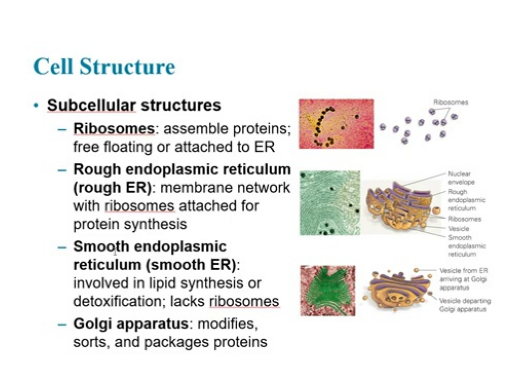

2024-06-27 22:13:37.245 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.245 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.245 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 0.0678,  0.0921,  0.2446,  0.2263,  0.1692,  0.1356,  0.2505,  0.0720,
         0.2227,  0.3269, -0.0279,  0.4220,  0.0512,  0.1453,  0.2380,  0.2452,
         0.0074, -0.0384,  0.0216,  0.1125,  0.0446, -0.0037,  0.2430,  0.4446,
        -0.0096,  0.3300,  0.0511,  0.1692,  0.2758,  0.0014,  0.3390,  0.1110,
         0.3397,  0.0379,  0.3592,  0.2634,  0.3193,  0.0295, -0.0052,  0.0297,
         0.0452,  0.2695, -0.0168,  0.4166,  0.1320,  0.2888,  0.2546,  0.0084,
         0.1675,  0.4239,  0.0587,  0.2504,  0.1333,  0.2036,  0.0952, -0.0040,
         0.4337,  0.2714,  0.0349,  0.2777,  0.1942,  0.5471,  0.0280,  0.

flavanol food sources


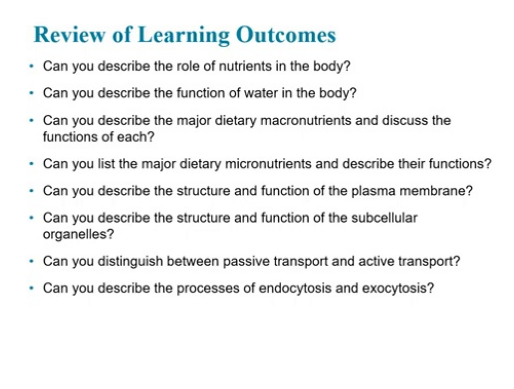

2024-06-27 22:13:37.380 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.380 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.380 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([-0.0291,  0.0425,  0.2826,  0.3602,  0.1682,  0.1219,  0.2196, -0.0388,
         0.2796,  0.3802, -0.0133,  0.3357, -0.0419,  0.2034,  0.1099,  0.2689,
         0.0665, -0.0564, -0.0107,  0.2372, -0.0110,  0.0490,  0.2831,  0.3533,
        -0.0032,  0.4175,  0.0685,  0.1682,  0.3498, -0.0332,  0.3120,  0.0804,
         0.3353,  0.0121,  0.2909,  0.2195,  0.3570,  0.0341, -0.0309, -0.0373,
         0.1669,  0.3631, -0.0286,  0.4529, -0.0540,  0.2335,  0.2161, -0.0611,
         0.2254,  0.4245,  0.0148,  0.2918,  0.1981,  0.1128,  0.2266, -0.0628,
         0.5194,  0.2701, -0.0693,  0.2842,  0.1905,  0.5891, -0.0085,  0.

what are the main food sources of lycopene red fruits


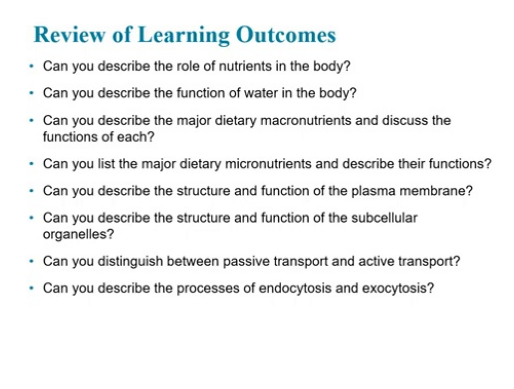

2024-06-27 22:13:37.473 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.473 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.473 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 0.5916,  0.2014,  0.1359,  0.1611,  0.0224,  0.2865,  0.1460,  0.5055,
         0.0855,  0.0236,  0.4403,  0.0912,  0.4885,  0.2972,  0.1537,  0.1671,
         0.4136,  0.6318,  0.3565,  0.2506,  0.3770,  0.3953,  0.0907,  0.0843,
         0.3196,  0.1543,  0.2170,  0.0224,  0.0795,  0.4286,  0.2391,  0.2314,
         0.2658,  0.4401,  0.0641,  0.1631,  0.0382,  0.2688,  0.3077,  0.5854,
         0.1730,  0.1279,  0.2587,  0.1066,  0.2842, -0.0020,  0.2188,  0.5501,
         0.2788,  0.0544,  0.6539,  0.2453,  0.2122,  0.3107,  0.2424,  0.5550,
         0.0545,  0.2671,  0.2160,  0.1772,  0.1660,  0.0309,  0.6037,  0.

plasma membrane


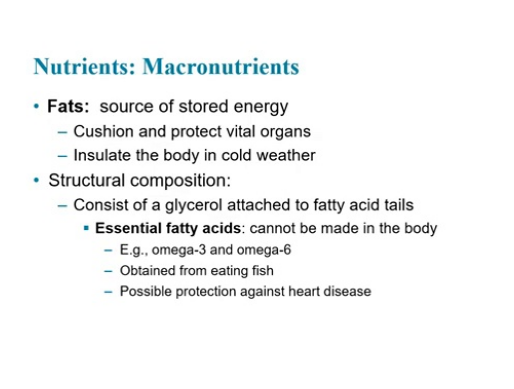

2024-06-27 22:13:37.580 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.580 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.583 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 0.2629,  0.2737,  0.1626,  0.1641, -0.0352,  0.4180,  0.1142,  0.1054,
         0.0554,  0.0121,  0.0621,  0.1165,  0.2322,  0.1751,  0.1251, -0.0081,
         0.2626,  0.1952,  0.2775,  0.2770,  0.2733,  0.2377,  0.0434,  0.1775,
         0.0630,  0.2280,  0.0961, -0.0352,  0.1527,  0.1719,  0.2486,  0.0910,
         0.1222,  0.2027,  0.0788,  0.0774,  0.0127,  0.1303,  0.1552,  0.1525,
         0.0693,  0.1392,  0.2433,  0.0874,  0.0858, -0.0136,  0.0500,  0.1778,
         0.1741,  0.0909,  0.3254,  0.3371,  0.0306,  0.1713,  0.2751,  0.1725,
         0.0845,  0.1418,  0.0198,  0.0281, -0.0335,  0.1417,  0.1199,  0.

chloroplast


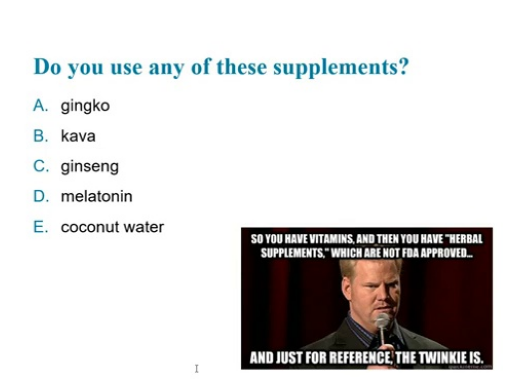

2024-06-27 22:13:37.680 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.680 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.693 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 0.4568,  0.1070,  0.1880,  0.2729,  0.0202,  0.2987,  0.1594,  0.4704,
         0.2067,  0.2527,  0.4958,  0.1550,  0.4487,  0.3924,  0.0599,  0.2621,
         0.5713,  0.5261,  0.4873,  0.6786,  0.5083,  0.6070,  0.2099, -0.0419,
         0.6688,  0.2760,  0.1930,  0.0202,  0.2374,  0.4825,  0.2500,  0.3355,
         0.5208,  0.4440,  0.1506,  0.2549,  0.2519,  0.2107,  0.5928,  0.5099,
         0.4153,  0.4221,  0.3781,  0.2858,  0.2274,  0.1751,  0.3682,  0.4914,
         0.3575,  0.1913,  0.4566,  0.4180,  0.3395,  0.4461,  0.6830,  0.4874,
         0.2613,  0.5548,  0.1449,  0.4405,  0.4190,  0.2648,  0.4829,  0.

explain subcellular structures such as the structures to recycle molecules in the digestive tract


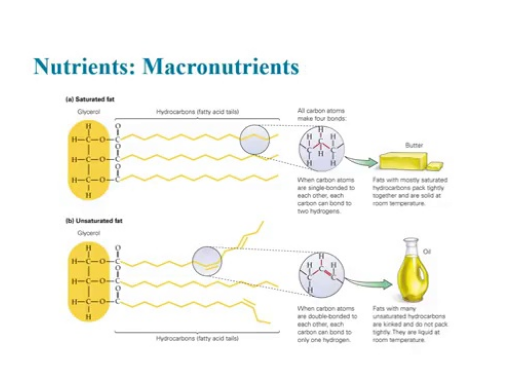

2024-06-27 22:13:37.794 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.794 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.794 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.2323, 0.0740, 0.1076, 0.1698, 0.0794, 0.1988, 0.1684, 0.2007, 0.0564,
        0.0618, 0.1005, 0.1332, 0.2173, 0.1606, 0.1191, 0.1125, 0.2378, 0.2415,
        0.2299, 0.2491, 0.2367, 0.2441, 0.0627, 0.1914, 0.1741, 0.2121, 0.1175,
        0.0794, 0.2173, 0.1882, 0.2370, 0.0859, 0.1852, 0.2180, 0.1165, 0.1270,
        0.0680, 0.1035, 0.2207, 0.2238, 0.0976, 0.1425, 0.1722, 0.2074, 0.0989,
        0.0781, 0.2150, 0.2298, 0.1541, 0.1553, 0.3306, 0.1816, 0.1211, 0.2012,
        0.2316, 0.2370, 0.1459, 0.2352, 0.0209, 0.1923, 0.1104, 0.2679, 0.2815,
        0.3169, 0.1910, 0.1738, 0.1211, 0.2189, 0.1217, 0.1345, 0.2284, 0.

centrioles


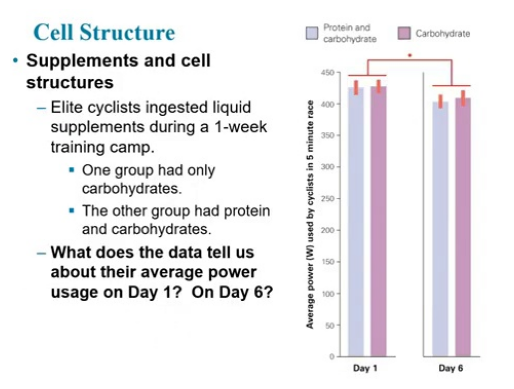

2024-06-27 22:13:37.919 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:37.919 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:37.919 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.3507, 0.0616, 0.0985, 0.3694, 0.0373, 0.4158, 0.0935, 0.3573, 0.1809,
        0.0774, 0.2907, 0.1271, 0.3511, 0.3995, 0.1772, 0.2032, 0.5000, 0.4440,
        0.4415, 0.5541, 0.4506, 0.5075, 0.1913, 0.0687, 0.3918, 0.1866, 0.2464,
        0.0373, 0.2032, 0.3382, 0.1698, 0.1281, 0.2898, 0.3247, 0.0420, 0.1582,
        0.0815, 0.2116, 0.5959, 0.5814, 0.1905, 0.1728, 0.3895, 0.1519, 0.1269,
        0.0819, 0.2906, 0.4099, 0.3571, 0.1644, 0.4016, 0.1763, 0.2094, 0.3252,
        0.5457, 0.4354, 0.1637, 0.3623, 0.0372, 0.2642, 0.2192, 0.2255, 0.4177,
        0.2688, 0.2948, 0.4012, 0.2094, 0.3485, 0.1634, 0.2089, 0.5777, 0.

role of centrioles for cell division


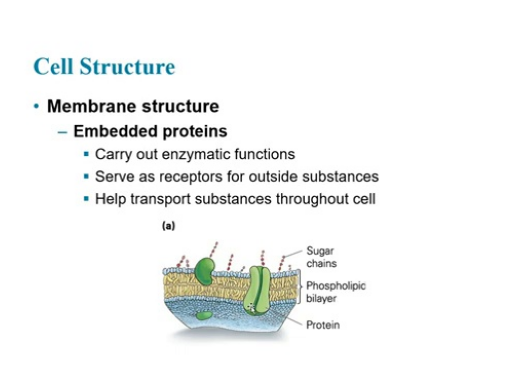

2024-06-27 22:13:38.013 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:38.013 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:38.013 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.7636, 0.2649, 0.1342, 0.1289, 0.1019, 0.2893, 0.1204, 0.7119, 0.0977,
        0.1149, 0.6645, 0.1711, 0.7649, 0.2949, 0.2005, 0.2721, 0.3755, 0.6420,
        0.4975, 0.3424, 0.5191, 0.3769, 0.1036, 0.0602, 0.4438, 0.2153, 0.2989,
        0.1019, 0.1205, 0.7041, 0.3369, 0.3291, 0.3269, 0.7019, 0.1230, 0.2039,
        0.1289, 0.3993, 0.3585, 0.5430, 0.2689, 0.2129, 0.4592, 0.1978, 0.4142,
        0.0556, 0.3381, 0.7188, 0.2776, 0.1297, 0.7711, 0.3812, 0.2311, 0.5442,
        0.3466, 0.7150, 0.1425, 0.3772, 0.3487, 0.2755, 0.2387, 0.1642, 0.6709,
        0.2987, 0.5218, 0.4321, 0.2311, 0.7844, 0.2413, 0.1224, 0.2288, 0.

transport across membranes


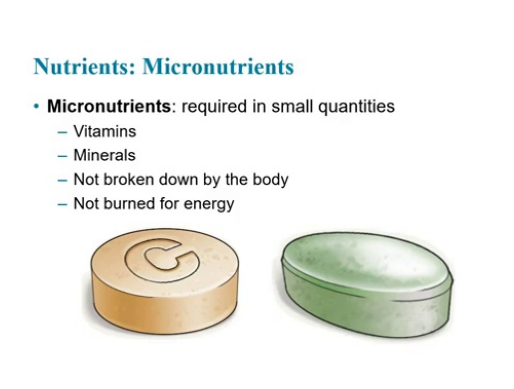

2024-06-27 22:13:38.114 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:38.114 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:38.130 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([0.7881, 0.2195, 0.1192, 0.1284, 0.0857, 0.2954, 0.0978, 0.6418, 0.0897,
        0.0948, 0.6200, 0.1066, 0.6711, 0.1956, 0.1959, 0.2096, 0.3226, 0.6001,
        0.4617, 0.2888, 0.4775, 0.3264, 0.0935, 0.0758, 0.3861, 0.1729, 0.2554,
        0.0857, 0.0849, 0.7043, 0.2854, 0.3394, 0.2504, 0.6866, 0.0846, 0.1669,
        0.0976, 0.5105, 0.3184, 0.4740, 0.2278, 0.1443, 0.4391, 0.1424, 0.3902,
        0.0429, 0.2977, 0.6891, 0.1737, 0.0701, 0.7064, 0.3642, 0.1974, 0.4907,
        0.2951, 0.6977, 0.0856, 0.3052, 0.3604, 0.1797, 0.2024, 0.1447, 0.5757,
        0.2291, 0.4721, 0.3740, 0.1974, 0.7067, 0.1819, 0.0797, 0.2077, 0.

passive transport methodologies across membranes


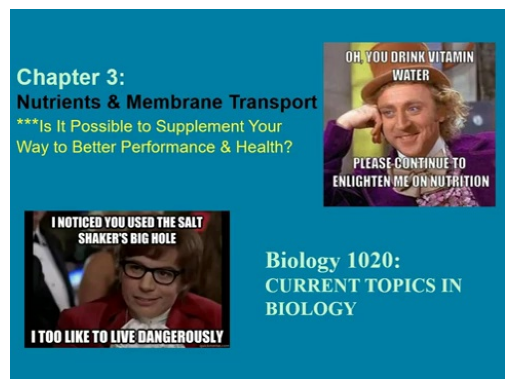

2024-06-27 22:13:38.240 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:38.240 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:38.240 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([ 1.2326e-01,  1.0800e-01, -1.3418e-02, -2.3330e-02,  1.1654e-01,
         1.3294e-01,  1.1953e-01,  8.6300e-02, -2.8613e-02,  5.2627e-02,
         7.8784e-02,  1.1143e-01,  1.6203e-01, -1.0595e-02,  4.6622e-01,
        -1.0737e-02,  5.4987e-02,  1.8272e-01,  4.9334e-02, -2.7887e-02,
         5.4041e-02,  4.1707e-02, -2.4471e-02,  2.4438e-01,  2.1878e-02,
         9.7240e-02,  1.9588e-01,  1.1654e-01,  2.2315e-02,  4.7837e-02,
         1.1883e-01,  1.0130e-01,  6.3994e-02,  1.0259e-01,  9.7913e-02,
        -5.9270e-03,  4.5198e-02,  8.0855e-02,  1.5180e-02,  6.4144e-02,
        -7.3070e-03, -3.7393e-02, -1.7443e-02,  1.

FDA testing


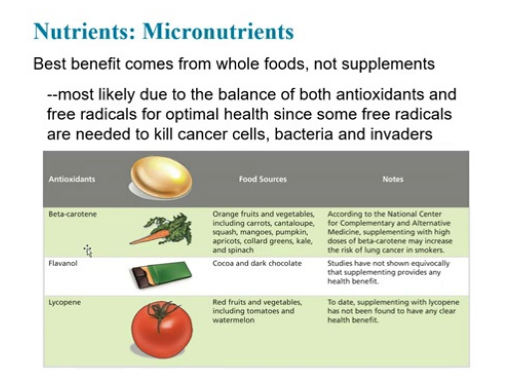

2024-06-27 22:13:38.365 | INFO     | src.clip.clip_model:search_similar_images:126 - Query text embedding shape: torch.Size([384])
2024-06-27 22:13:38.365 | INFO     | src.clip.clip_model:search_similar_images:127 - Text embeddings shape: torch.Size([142, 384])
2024-06-27 22:13:38.365 | INFO     | src.clip.clip_model:search_similar_images:131 - Similarity scores: tensor([-0.0505,  0.1528,  0.1933,  0.1175,  0.2261,  0.1429,  0.0960, -0.0237,
         0.0626,  0.0026, -0.0536,  0.0647, -0.0452,  0.0545,  0.2256, -0.0386,
        -0.0486, -0.0640, -0.0431, -0.0946, -0.0446, -0.0636,  0.0656,  0.1861,
        -0.1224,  0.0692,  0.1079,  0.2261,  0.0839, -0.0776,  0.1235,  0.1493,
         0.0334, -0.0401,  0.2142,  0.1399, -0.0096,  0.1212, -0.1011, -0.1041,
        -0.0170, -0.0730, -0.0532,  0.0643,  0.0131, -0.0332, -0.0515, -0.0226,
         0.0599,  0.1117,  0.0135,  0.0653,  0.1037,  0.1782, -0.0951, -0.0372,
         0.0774,  0.0222, -0.0092,  0.0640,  0.0268,  0.0537, -0.0904,  0.

legal requirements for health impact


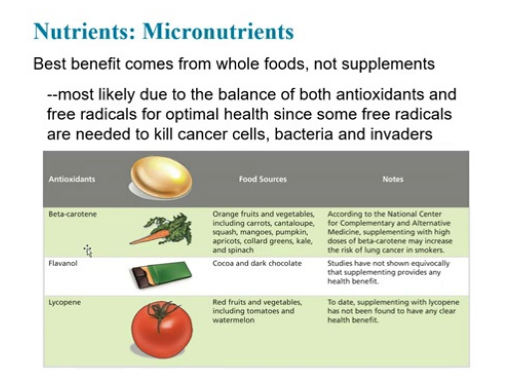

In [120]:
for i, row in df.iterrows():
    logger.info(row['Prompt'])
    # get prompt 
    prompt = row['Prompt']
    # search for similar images
    clip_model.search_similar_images(prompt)

In [114]:
# print pickle file 
with open("bio_3_3_th5.pickle", "rb") as file:
    data = pickle.load(file)
    
logger.info(f"new_pickle: {data}")

2024-06-27 22:07:42.527 | INFO     | __main__:<module>:5 - new_pickle: {79: {'img_path': '/Users/magic-rabbit/Documents/AFM/afm-vlm/data/raw/biology_chapter_3_3_treshhold_5/extracted_keyframes/biology_chapter_3_3_treshhold_5-Scene-079-01.jpg', 'timestamps': [3639.0, 3639.8], 'transcription': '', 'ocr_extracted_text': 'Transport Across Membranes\n\n+ Exocytosis: a membrane-bound vesicle fuses with the\nmembrane and expels the large molecule outside the cell\n\n(2) Exocytosis\n\n', 'llava_result': " The slide appears to be from an academic lecture, specifically focusing on the topic of transport across membranes. Here's a breakdown of the content:\n\n**Headline:** Transport Across Membranes\n\n**Summary:** The slide explains the three main types of transport across cell membranes: simple diffusion, facilitated diffusion, and active transport. It uses visual aids to illustrate these processes.\n\n**Figures:**\n\n1. **Simple Diffusion (Figure 1):** This figure shows two cells with a membra

In [115]:
# set image paths for the experiments
extracted_data_path = [data[key]['img_path'] for key in data.keys() if
                       'img_path' in data[key]]
clip_model.img_paths = extracted_data_path

In [116]:
# Embedded with standard Tokenizer: Only OCR
logger.info(f"Embedded with standard Tokenizer: Only OCR")

extracted_data_ocr_text = [data[key]['ocr_extracted_text'] for key in data.keys() if
                       'ocr_extracted_text' in data[key]]

logger.info(extracted_data_ocr_text)

# get the embedder model
embedder_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

ocr_embeddings = text_to_embedding_transformer(extracted_data_ocr_text, embedder_model)

logger.info('OCR Embeddings: ', ocr_embeddings)

clip_model.text_embeddings = ocr_embeddings

PROMPT = "subcellular structures"

clip_model.search_similar_images(PROMPT)


2024-06-27 22:07:47.783 | INFO     | __main__:<module>:2 - Embedded with standard Tokenizer: Only OCR
2024-06-27 22:07:47.788 | INFO     | __main__:<module>:7 - ['Transport Across Membranes\n\n+ Exocytosis: a membrane-bound vesicle fuses with the\nmembrane and expels the large molecule outside the cell\n\n(2) Exocytosis\n\n', 'Do you use any of these supplements?\n\n>\n\ngingko\nkava\nginseng\n\nmelatonin\n\nmooo\n\ncoconut water\n\n‘$0 YOU WAVE VITAMINS, AND THEN YOU HAVE "HERBAL\nSUPPLEMENTS." WHICH ARE WOT FDA APPROVED.\n\nL\n‘AND JUST FOR REFERENCE, THE TWINKIE IS.\n\n', 'Transport Across Membranes\n\n* Membrane transport\n— Plasma membrane:\nphospholipid bilayer is\ndifferentially permeable\n= Hydrophobic substances\n\n', 'Nutrients: Macronutrients\n\n* Carbohydrates: main energy\n\nsource Fructose e\n+ Possible structural composition: =\n— Single-unit simple sugars\n(monosaccharides)\n~ Many sugar subunits o\n(polysaccharides) (s)crapefined 2) Grapes\nuy\n\n* arranged in branchin

SSLError: (MaxRetryError('HTTPSConnectionPool(host=\'huggingface.co\', port=443): Max retries exceeded with url: /sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2/resolve/main/config.json (Caused by SSLError(SSLCertVerificationError(1, "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for \'huggingface.co\'. (_ssl.c:1000)")))'), '(Request ID: 20c2577c-8694-40ec-bd3e-2c0edbc495ee)')

In [ ]:
# Embedded with standard Tokenizer: OCR * Transcriptions 
logger.info(f"Embedded with standard Tokenizer: OCR * Transcriptions")

clip_model.text_embeddings = None

extracted_data_ocr_text = [data[key]['ocr_extracted_text'] for key in data.keys() if
                       'ocr_extracted_text' in data[key]]

logger.info(extracted_data_ocr_text)

extracted_data_transcriptions = [data[key]['transcriptions'] for key in data.keys() if
                       'transcriptions' in data[key]]

# concatenate ocr and transcriptions
concat_result = extracted_data_ocr_text.append(extracted_data_transcriptions)
logger.info('Concatenated Result: ', concat_result)

# get the embedder model
embedder_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

concat_result_embeddings = text_to_embedding_transformer(concat_result, embedder_model)

logger.info('concat_result_embeddings: ', concat_result_embeddings)

clip_model.text_embeddings = concat_result_embeddings

PROMPT = "subcellular structures"

clip_model.search_similar_images(PROMPT)

In [ ]:
# Embedded with standard Tokenizer: OCR * LLAVA
logger.info(f"Embedded with standard Tokenizer: OCR * LLAVA")

clip_model.text_embeddings = None

extracted_data_ocr_text = [data[key]['ocr_extracted_text'] for key in data.keys() if
                       'ocr_extracted_text' in data[key]]

logger.info(extracted_data_ocr_text)

extracted_data_llava_result = [data[key]['llava_result'] for key in data.keys() if
                       'llava_result' in data[key]]

# concatenate ocr and transcriptions
concat_result = extracted_data_ocr_text.append(extracted_data_llava_result)
logger.info('Concatenated Result: ', concat_result)

# get the embedder model
embedder_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

concat_result_embeddings = text_to_embedding_transformer(concat_result, embedder_model)

logger.info('concat_result_embeddings: ', concat_result_embeddings)

clip_model.text_embeddings = concat_result_embeddings

PROMPT = "subcellular structures"

clip_model.search_similar_images(PROMPT)

In [ ]:
# Embedded with standard Tokenizer - clip_llm_summary: OCR * Transcriptions * LLAVA 
logger.info(f"Embedded with standard Tokenizer - clip_llm_summary: OCR * LLAVA * Transcriptions")

clip_model.text_embeddings = None 

# Assuming that the pickle file has standard tokenizer embeddings 
extracted_data_text = [data[key]['clip_text_embedding'] for key in data.keys() if
                       'clip_text_embedding' in data[key]]

clip_text_embeddings = [data[0] for data in extracted_data_text]

clip_model.text_embeddings = clip_text_embeddings

if isinstance(clip_model.text_embeddings, list):
    for i, text_embedding in enumerate(clip_model.text_embeddings):
        clip_model.text_embeddings[i] = torch.tensor(text_embedding)

# create one single torch for sim search 
clip_model.text_embeddings = torch.stack(clip_model.text_embeddings, dim=0)
print(clip_model.text_embeddings.shape)

In [ ]:
# Embedded with standard Tokenizer - extensive_summary: OCR * Transcriptions * LLAVA
logger.info(f"Embedded with standard Tokenizer - extensive_summary : OCR * LLAVA * Transcriptions")

clip_model.text_embeddings = None 

extracted_data_text = [data[key]['llm_long_summary'] for key in data.keys() if
                       'llm_long_summary' in data[key]]

clip_text_embeddings = [data[0] for data in extracted_data_text]

clip_model.text_embeddings = clip_text_embeddings

if isinstance(clip_model.text_embeddings, list):
    for i, text_embedding in enumerate(clip_model.text_embeddings):
        clip_model.text_embeddings[i] = torch.tensor(text_embedding)

# create one single torch for sim search 
clip_model.text_embeddings = torch.stack(clip_model.text_embeddings, dim=0)
print(clip_model.text_embeddings.shape)


In [ ]:
# Embedded with CLIP - clip_llm_summary: OCR * Transcriptions * LLAVA 
logger.info(f" Embedded with CLIP - clip_llm_summary: OCR * Transcriptions * LLAVA")

clip_model.text_embeddings = None 

extracted_data_text = [data[key]['clip_text_embedding'] for key in data.keys() if
                       'clip_text_embedding' in data[key]]

clip_text_embeddings = [data[0] for data in extracted_data_text]

clip_model.text_embeddings = clip_text_embeddings

if isinstance(clip_model.text_embeddings, list):
    for i, text_embedding in enumerate(clip_model.text_embeddings):
        clip_model.text_embeddings[i] = torch.tensor(text_embedding)

# create one single torch for sim search 
clip_model.text_embeddings = torch.stack(clip_model.text_embeddings, dim=0)
print(clip_model.text_embeddings.shape)

In [ ]:
####################TEST 1: Search for exact similar Text.####################
base_dir = "../.."

test_image_path = os.path.join(
    base_dir,
    "data",
    "raw",
    "biology_chapter_3_3",
    "extracted_keyframes",
    "biology_chapter_3_3-Scene-097-01.jpg",
)

test_text_description = extract_text_from_image(test_image_path)

prompt = "subcellular structures"

print("Test Text Description: ", test_text_description)

clip_model.search_similar_images(prompt)

In [78]:
# Embedded with CLIP - extensive_summary: OCR * Transcriptions * LLAVA 
logger.info(f" Embedded with CLIP - extensive_summary: OCR * Transcriptions * LLAVA")

clip_model.text_embeddings = None

extracted_data_extensive_summary = [data[key]['llm_long_summary'] for key in data.keys() if
                       'llm_long_summary' in data[key]]
logger.info(f"Extracted_data llm_long_summary: {extracted_data_extensive_summary}")

#clip_text_embeddings_extensive = [data[0] for data in extracted_data_extensive_summary]

#logger.info(f"Clip_text_embeddings_extensive: {clip_text_embeddings_extensive}")

clip_model.text_embeddings = extracted_data_extensive_summary

logger.info(f"Clip_model.text_embeddings: {clip_model.text_embeddings}")

if isinstance(clip_model.text_embeddings, list):
    for i, text_embedding in enumerate(clip_model.text_embeddings):
        clip_model.text_embeddings[i] = torch.tensor(text_embedding)

# create one single torch for sim search 
clip_model.text_embeddings = torch.stack(clip_model.text_embeddings, dim=0)


2024-06-27 10:31:10.379 | INFO     | __main__:<module>:4 - Extracted_data llm_long_summary: ['Here is a summary of the lecture content:\n\nTransport Across Membranes: Diffusion\nDiffusion is a passive transport process where molecules move from an area of high concentration to an area of low concentration without any external force or energy input. This process occurs in very small, hydrophobic molecules that can easily cross cell membranes. The movement of molecules is driven by the concentration gradient, with molecules moving down their concentration gradient until equilibrium is reached.', 'The lecture discussed how many liters of water are lost by an average human each day. The correct answer is three liters, which is likely an estimate based on various factors such as food production, transportation, and other human activities that consume water resources. The slide featured a humorous image of Yoda with the caption "Fight fatigue with water," highlighting the importance of stayi

TypeError: new(): invalid data type 'str'

In [89]:
import pandas as pd

# Load csv file
filename = "test_frames_gt.csv"
df = pd.read_csv(filename)

In [90]:
df['Prompt']

0                                     learning outcomes
1     retrieve the main learning outcomes from the l...
2                    explain proteins in macronutrients
3     I did not understand the function of proteins ...
4                                     fish oil capsules
5     what is the functioning of fish oil capsules a...
6                              calcium as micronutrient
7             what is calcium commonly supplemented for
8                                 flavanol food sources
9     what are the main food sources of lycopene red...
10                                      plasma membrane
11                                          chloroplast
12    explain subcellular structures such as the str...
13                                           centrioles
14                 role of centrioles for cell division
15                           transport across membranes
16     passive transport methodologies across membranes
17                                          FDA 

In [91]:
for i, row in df.iterrows():
    print(row['Prompt'])
    # get prompt 
    prompt = row['Prompt']
    # search for similar images
    clip_model.search_similar_images(prompt)

learning outcomes


AttributeError: 'list' object has no attribute 'shape'